In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
import pickle
import os
import NN
from glob import glob

In [2]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [3]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            #  filtered_data.append([0,0,0])
            # points_removed.append(point)
    return filtered_data

In [4]:
test_files = './cluster_data/padded/picking_up/test/katie_point_taken_poss_matrix1.pkl'
with open(test_files, 'rb') as file:
    test_data = pickle.load(file)
print(test_data)

[array([[-2.47558594e-01,  1.33496094e+00,  8.91601562e-01,
         1.25244141e-01,  2.62000000e+02],
       [-2.72460938e-01,  1.44433594e+00,  1.14453125e+00,
         2.50488281e-01,  2.27000000e+02],
       [-2.35351562e-01,  1.29785156e+00,  7.97851562e-01,
         2.50488281e-01,  3.81000000e+02],
       [-1.86523438e-01,  1.25292969e+00,  5.43945312e-01,
        -1.25244141e-01,  2.14000000e+02],
       [-2.98339844e-01,  1.30761719e+00,  7.83203125e-01,
         2.50488281e-01,  3.43000000e+02],
       [-2.59765625e-01,  1.39941406e+00,  1.02246094e+00,
         3.75732422e-01,  2.76000000e+02],
       [-3.22753906e-01,  1.39062500e+00,  6.08398438e-01,
        -2.50488281e-01,  2.50000000e+02],
       [-1.72851562e-01,  1.25488281e+00,  7.86132812e-01,
         5.00976562e-01,  3.61000000e+02],
       [-3.90869141e-01,  1.39062500e+00,  5.89843750e-01,
        -3.75732422e-01,  2.53000000e+02],
       [-3.32275391e-01,  1.35449219e+00,  6.33789062e-01,
        -2.50488281e-0

In [41]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    train_points_sample.append(bg_rm_arr)
                train_points_sample = np.array(train_points_sample).reshape(-1,5)
                train_points.append(train_points_sample)
                train_labels.append(i)
               
        
        for f in test_files:
            test_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    test_points_sample.append(bg_rm_arr)
                test_points_sample = np.array(test_points_sample).reshape(-1,5)
                test_points.append(test_points_sample)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [42]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: jumping
processing class: picking_up
processing class: sitting
processing class: walking
train_points shape: (1393, 300, 5)
test_points shape: (349, 300, 5)
train_labels shape: (1393,)
test_labels shape: (349,)


In [7]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [44]:
train_size = 0.8
seed = 42
BATCH_SIZE = 32
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))

train_dataset_size = int(len(dataset) * train_size)


dataset = dataset.shuffle(len(train_points), seed=seed)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [12]:
from keras import models, layers

In [46]:
# Define the input shape (5 features)
input_shape = (None, 5)

# Define the model
model = models.Sequential()
sequence_length = 300
num_features = 5
num_classes = 4


# 1. CNN layer
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D(pool_size=2))

# LSTM layer
model.add(layers.LSTM(64, input_shape=(sequence_length, num_features), return_sequences=False))

# Fully connected (Dense) layer
model.add(layers.Dense(32, activation='relu'))

# Output layer with Softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))




c:\Users\Yang Qian\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Yang Qian\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, None, 64)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,260 (141.64 KB)

 Trainable params: 36,260 (141.64 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, 
                    epochs=200, 
                    validation_data=(validation_dataset), 
                    verbose=1, 
                    callbacks=[early_stopping]
                )

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.3335 - loss: 1.3453 - val_accuracy: 0.3082 - val_loss: 1.3285
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3345 - loss: 1.3157 - val_accuracy: 0.3763 - val_loss: 1.2612
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3645 - loss: 1.2859 - val_accuracy: 0.4050 - val_loss: 1.2551
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3686 - loss: 1.2907 - val_accuracy: 0.4624 - val_loss: 1.2819
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4717 - loss: 1.2222 - val_accuracy: 0.4910 - val_loss: 1.1283
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4620 - loss: 1.1943 - val_accuracy: 0.4767 - val_loss: 1.1756
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4598 - loss: 1.2119 - val_accuracy: 0.4444 - val_loss: 1.1964
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4599 - loss: 1.1719 - val_accuracy: 0.

In [36]:
test_loss, test_acc = model.evaluate(test_points, test_labels, verbose=1)
# Print test accuracy
print(f'Test accuracy: {test_acc:.4f}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4925 - loss: 2.3698
Test accuracy: 0.5330


In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Make predictions on the test set
predictions = model.predict(test_points)

# Convert probabilities to predicted class labels (0, 1, or 2)
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(test_labels, predicted_classes)
print("Classification Report:")
print(class_report)

# Evaluate the model's accuracy
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Test Accuracy: {accuracy:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix:
[[33 43  3  1]
 [ 0 43 25 12]
 [ 0  3 66  0]
 [ 0 59 17 44]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.41      0.58        80
           1       0.29      0.54      0.38        80
           2       0.59      0.96      0.73        69
           3       0.77      0.37      0.50       120

    accuracy                           0.53       349
   macro avg       0.66      0.57      0.55       349
weighted avg       0.68      0.53      0.54       349

Test Accuracy: 0.5330


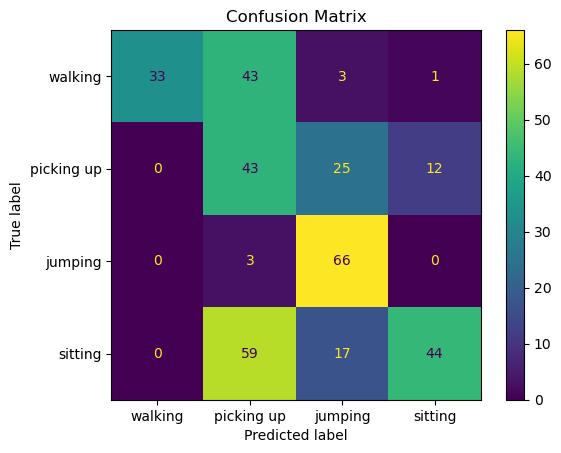

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
predicted_classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_classes)

# Plotting the confusion matrix
class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
# class_names = ['jumping','picking up','sitting','walking']
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()
